In [36]:
# Chạy 1 lần 
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install torchvision
# !pip install matplotlib
# !pip install torch
# !pip install einops

In [37]:
# !pip install einops

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class my_Layernorm(nn.Module):
    """
    Special designed layernorm for the seasonal part
    """

    def __init__(self, channels):
        super(my_Layernorm, self).__init__()
        self.layernorm = nn.LayerNorm(channels)

    def forward(self, x):
        x_hat = self.layernorm(x)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        return x_hat - bias


class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean


class series_decomp_multi(nn.Module):
    """
    Multiple Series decomposition block from FEDformer
    """

    def __init__(self, kernel_size):
        super(series_decomp_multi, self).__init__()
        self.kernel_size = kernel_size
        self.series_decomp = [series_decomp(kernel) for kernel in kernel_size]

    def forward(self, x):
        moving_mean = []
        res = []
        for func in self.series_decomp:
            sea, moving_avg = func(x)
            moving_mean.append(moving_avg)
            res.append(sea)

        sea = sum(res) / len(res)
        moving_mean = sum(moving_mean) / len(moving_mean)
        return sea, moving_mean


class EncoderLayer(nn.Module):
    """
    Autoformer encoder layer with the progressive decomposition architecture
    """

    def __init__(self, attention, d_model, d_ff=None, moving_avg=25, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        x, _ = self.decomp1(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        res, _ = self.decomp2(x + y)
        return res, attn


class Encoder(nn.Module):
    """
    Autoformer encoder
    """

    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


class DecoderLayer(nn.Module):
    """
    Autoformer decoder layer with the progressive decomposition architecture
    """

    def __init__(self, self_attention, cross_attention, d_model, c_out, d_ff=None,
                 moving_avg=25, dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.decomp3 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=3, stride=1, padding=1,
                                    padding_mode='circular', bias=False)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x, trend1 = self.decomp1(x)
        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])
        x, trend2 = self.decomp2(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        x, trend3 = self.decomp3(x + y)

        residual_trend = trend1 + trend2 + trend3
        residual_trend = self.projection(residual_trend.permute(0, 2, 1)).transpose(1, 2)
        return x, residual_trend


class Decoder(nn.Module):
    """
    Autoformer encoder
    """

    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, trend=None):
        for layer in self.layers:
            x, residual_trend = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)
            trend = trend + residual_trend

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x, trend


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import math


class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3, 'D': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(
                x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)


class DataEmbedding_inverted(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(c_in, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = x.permute(0, 2, 1)
        # x: [Batch Variate Time]
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1))
        # x: [Batch Variate d_model]
        return self.dropout(x)


class DataEmbedding_wo_pos(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_wo_pos, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark)
        return self.dropout(x)


class PatchEmbedding(nn.Module):
    def __init__(self, d_model, patch_len, stride, padding, dropout):
        super(PatchEmbedding, self).__init__()
        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch_layer = nn.ReplicationPad1d((0, padding))

        # Backbone, Input encoding: projection of feature vectors onto a d-dim vector space
        self.value_embedding = nn.Linear(patch_len, d_model, bias=False)

        # Positional embedding
        self.position_embedding = PositionalEmbedding(d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # do patching
        n_vars = x.shape[1]
        x = self.padding_patch_layer(x)
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        # Input encoding
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x), n_vars


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft as fft
from einops import rearrange, reduce, repeat
import math, random
from scipy.fftpack import next_fast_len


class Transform:
    def __init__(self, sigma):
        self.sigma = sigma

    @torch.no_grad()
    def transform(self, x):
        return self.jitter(self.shift(self.scale(x)))

    def jitter(self, x):
        return x + (torch.randn(x.shape).to(x.device) * self.sigma)

    def scale(self, x):
        return x * (torch.randn(x.size(-1)).to(x.device) * self.sigma + 1)

    def shift(self, x):
        return x + (torch.randn(x.size(-1)).to(x.device) * self.sigma)


def conv1d_fft(f, g, dim=-1):
    N = f.size(dim)
    M = g.size(dim)

    fast_len = next_fast_len(N + M - 1)

    F_f = fft.rfft(f, fast_len, dim=dim)
    F_g = fft.rfft(g, fast_len, dim=dim)

    F_fg = F_f * F_g.conj()
    out = fft.irfft(F_fg, fast_len, dim=dim)
    out = out.roll((-1,), dims=(dim,))
    idx = torch.as_tensor(range(fast_len - N, fast_len)).to(out.device)
    out = out.index_select(dim, idx)

    return out


class ExponentialSmoothing(nn.Module):

    def __init__(self, dim, nhead, dropout=0.1, aux=False):
        super().__init__()
        self._smoothing_weight = nn.Parameter(torch.randn(nhead, 1))
        self.v0 = nn.Parameter(torch.randn(1, 1, nhead, dim))
        self.dropout = nn.Dropout(dropout)
        if aux:
            self.aux_dropout = nn.Dropout(dropout)

    def forward(self, values, aux_values=None):
        b, t, h, d = values.shape

        init_weight, weight = self.get_exponential_weight(t)
        output = conv1d_fft(self.dropout(values), weight, dim=1)
        output = init_weight * self.v0 + output

        if aux_values is not None:
            aux_weight = weight / (1 - self.weight) * self.weight
            aux_output = conv1d_fft(self.aux_dropout(aux_values), aux_weight)
            output = output + aux_output

        return output

    def get_exponential_weight(self, T):
        # Generate array [0, 1, ..., T-1]
        powers = torch.arange(T, dtype=torch.float, device=self.weight.device)

        # (1 - \alpha) * \alpha^t, for all t = T-1, T-2, ..., 0]
        weight = (1 - self.weight) * (self.weight ** torch.flip(powers, dims=(0,)))

        # \alpha^t for all t = 1, 2, ..., T
        init_weight = self.weight ** (powers + 1)

        return rearrange(init_weight, 'h t -> 1 t h 1'), \
               rearrange(weight, 'h t -> 1 t h 1')

    @property
    def weight(self):
        return torch.sigmoid(self._smoothing_weight)


class Feedforward(nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout=0.1, activation='sigmoid'):
        # Implementation of Feedforward model
        super().__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward, bias=False)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, bias=False)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = getattr(F, activation)

    def forward(self, x):
        x = self.linear2(self.dropout1(self.activation(self.linear1(x))))
        return self.dropout2(x)


class GrowthLayer(nn.Module):

    def __init__(self, d_model, nhead, d_head=None, dropout=0.1):
        super().__init__()
        self.d_head = d_head or (d_model // nhead)
        self.d_model = d_model
        self.nhead = nhead

        self.z0 = nn.Parameter(torch.randn(self.nhead, self.d_head))
        self.in_proj = nn.Linear(self.d_model, self.d_head * self.nhead)
        self.es = ExponentialSmoothing(self.d_head, self.nhead, dropout=dropout)
        self.out_proj = nn.Linear(self.d_head * self.nhead, self.d_model)

        assert self.d_head * self.nhead == self.d_model, "d_model must be divisible by nhead"

    def forward(self, inputs):
        """
        :param inputs: shape: (batch, seq_len, dim)
        :return: shape: (batch, seq_len, dim)
        """
        b, t, d = inputs.shape
        values = self.in_proj(inputs).view(b, t, self.nhead, -1)
        values = torch.cat([repeat(self.z0, 'h d -> b 1 h d', b=b), values], dim=1)
        values = values[:, 1:] - values[:, :-1]
        out = self.es(values)
        out = torch.cat([repeat(self.es.v0, '1 1 h d -> b 1 h d', b=b), out], dim=1)
        out = rearrange(out, 'b t h d -> b t (h d)')
        return self.out_proj(out)


class FourierLayer(nn.Module):

    def __init__(self, d_model, pred_len, k=None, low_freq=1):
        super().__init__()
        self.d_model = d_model
        self.pred_len = pred_len
        self.k = k
        self.low_freq = low_freq

    def forward(self, x):
        """x: (b, t, d)"""
        b, t, d = x.shape
        x_freq = fft.rfft(x, dim=1)

        if t % 2 == 0:
            x_freq = x_freq[:, self.low_freq:-1]
            f = fft.rfftfreq(t)[self.low_freq:-1]
        else:
            x_freq = x_freq[:, self.low_freq:]
            f = fft.rfftfreq(t)[self.low_freq:]

        x_freq, index_tuple = self.topk_freq(x_freq)
        f = repeat(f, 'f -> b f d', b=x_freq.size(0), d=x_freq.size(2))
        f = rearrange(f[index_tuple], 'b f d -> b f () d').to(x_freq.device)

        return self.extrapolate(x_freq, f, t)

    def extrapolate(self, x_freq, f, t):
        x_freq = torch.cat([x_freq, x_freq.conj()], dim=1)
        f = torch.cat([f, -f], dim=1)
        t_val = rearrange(torch.arange(t + self.pred_len, dtype=torch.float),
                          't -> () () t ()').to(x_freq.device)

        amp = rearrange(x_freq.abs() / t, 'b f d -> b f () d')
        phase = rearrange(x_freq.angle(), 'b f d -> b f () d')

        x_time = amp * torch.cos(2 * math.pi * f * t_val + phase)

        return reduce(x_time, 'b f t d -> b t d', 'sum')

    def topk_freq(self, x_freq):
        values, indices = torch.topk(x_freq.abs(), self.k, dim=1, largest=True, sorted=True)
        mesh_a, mesh_b = torch.meshgrid(torch.arange(x_freq.size(0)), torch.arange(x_freq.size(2)))
        index_tuple = (mesh_a.unsqueeze(1), indices, mesh_b.unsqueeze(1))
        x_freq = x_freq[index_tuple]

        return x_freq, index_tuple


class LevelLayer(nn.Module):

    def __init__(self, d_model, c_out, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.c_out = c_out

        self.es = ExponentialSmoothing(1, self.c_out, dropout=dropout, aux=True)
        self.growth_pred = nn.Linear(self.d_model, self.c_out)
        self.season_pred = nn.Linear(self.d_model, self.c_out)

    def forward(self, level, growth, season):
        b, t, _ = level.shape
        growth = self.growth_pred(growth).view(b, t, self.c_out, 1)
        season = self.season_pred(season).view(b, t, self.c_out, 1)
        growth = growth.view(b, t, self.c_out, 1)
        season = season.view(b, t, self.c_out, 1)
        level = level.view(b, t, self.c_out, 1)
        out = self.es(level - season, aux_values=growth)
        out = rearrange(out, 'b t h d -> b t (h d)')
        return out


class EncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, c_out, seq_len, pred_len, k, dim_feedforward=None, dropout=0.1,
                 activation='sigmoid', layer_norm_eps=1e-5):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.c_out = c_out
        self.seq_len = seq_len
        self.pred_len = pred_len
        dim_feedforward = dim_feedforward or 4 * d_model
        self.dim_feedforward = dim_feedforward

        self.growth_layer = GrowthLayer(d_model, nhead, dropout=dropout)
        self.seasonal_layer = FourierLayer(d_model, pred_len, k=k)
        self.level_layer = LevelLayer(d_model, c_out, dropout=dropout)

        # Implementation of Feedforward model
        self.ff = Feedforward(d_model, dim_feedforward, dropout=dropout, activation=activation)
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, res, level, attn_mask=None):
        season = self._season_block(res)
        res = res - season[:, :-self.pred_len]
        growth = self._growth_block(res)
        res = self.norm1(res - growth[:, 1:])
        res = self.norm2(res + self.ff(res))

        level = self.level_layer(level, growth[:, :-1], season[:, :-self.pred_len])
        return res, level, growth, season

    def _growth_block(self, x):
        x = self.growth_layer(x)
        return self.dropout1(x)

    def _season_block(self, x):
        x = self.seasonal_layer(x)
        return self.dropout2(x)


class Encoder(nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, res, level, attn_mask=None):
        growths = []
        seasons = []
        for layer in self.layers:
            res, level, growth, season = layer(res, level, attn_mask=None)
            growths.append(growth)
            seasons.append(season)

        return level, growths, seasons


class DampingLayer(nn.Module):

    def __init__(self, pred_len, nhead, dropout=0.1):
        super().__init__()
        self.pred_len = pred_len
        self.nhead = nhead
        self._damping_factor = nn.Parameter(torch.randn(1, nhead))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = repeat(x, 'b 1 d -> b t d', t=self.pred_len)
        b, t, d = x.shape

        powers = torch.arange(self.pred_len).to(self._damping_factor.device) + 1
        powers = powers.view(self.pred_len, 1)
        damping_factors = self.damping_factor ** powers
        damping_factors = damping_factors.cumsum(dim=0)
        x = x.view(b, t, self.nhead, -1)
        x = self.dropout(x) * damping_factors.unsqueeze(-1)
        return x.view(b, t, d)

    @property
    def damping_factor(self):
        return torch.sigmoid(self._damping_factor)


class DecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, c_out, pred_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.c_out = c_out
        self.pred_len = pred_len

        self.growth_damping = DampingLayer(pred_len, nhead, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, growth, season):
        growth_horizon = self.growth_damping(growth[:, -1:])
        growth_horizon = self.dropout1(growth_horizon)

        seasonal_horizon = season[:, -self.pred_len:]
        return growth_horizon, seasonal_horizon


class Decoder(nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.d_model = layers[0].d_model
        self.c_out = layers[0].c_out
        self.pred_len = layers[0].pred_len
        self.nhead = layers[0].nhead

        self.layers = nn.ModuleList(layers)
        self.pred = nn.Linear(self.d_model, self.c_out)

    def forward(self, growths, seasons):
        growth_repr = []
        season_repr = []

        for idx, layer in enumerate(self.layers):
            growth_horizon, season_horizon = layer(growths[idx], seasons[idx])
            growth_repr.append(growth_horizon)
            season_repr.append(season_horizon)
        growth_repr = sum(growth_repr)
        season_repr = sum(season_repr)
        return self.pred(growth_repr), self.pred(season_repr)


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# from Model.MICN.layers.Embed import DataEmbedding
# from Model.MICN.layers.Autoformer_EncDec import series_decomp, series_decomp_multi

In [42]:
# Giả sử các lớp DataEmbedding, series_decomp, và series_decomp_multi đã được định nghĩa trong layers.Embed và layers.Autoformer_EncDec.


class MIC(nn.Module):
    """
    Mô hình MIC đơn giản với một lớp Linear.
    """
    def __init__(self, configs):
        super(MIC, self).__init__()
        self.layer = nn.Linear(configs.d_model, configs.d_model)

    def forward(self, x):
        return self.layer(x)


In [43]:

class SeasonalPrediction(nn.Module):
    """
    Khối dự báo mùa vụ với một lớp Linear.
    """
    def __init__(self, configs):
        super(SeasonalPrediction, self).__init__()
        self.layer = nn.Linear(configs.d_model, configs.pred_len)

    def forward(self, x):
        return self.layer(x)


In [44]:

class Model(nn.Module):
    """
    Mô hình chính bao gồm các khối embedding, encoder và decoder.
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq, configs.dropout)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=configs.d_model, nhead=configs.n_heads, dropout=configs.dropout),
            num_layers=configs.d_layers)
        self.decoder = nn.Linear(configs.d_model, 1)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        enc_out = self.embedding(x_enc, x_mark_enc)
        enc_out = self.encoder(enc_out)
        dec_out = self.decoder(enc_out[:, -1, :])
        return dec_out.squeeze(-1)


In [45]:
def evaluate_forecast(true_values, predicted_values):
    """
    Hàm tính toán các chỉ số đánh giá cho dự báo.
    """
    rmse = np.sqrt(np.mean((true_values - predicted_values) ** 2))
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    mae = np.mean(np.abs(true_values - predicted_values))
    return rmse, mape, mae

In [46]:
import matplotlib.pyplot as plt

def export_forecast_by_datasets(datasets, index_col, attribute, train_ratios, prediction_lengths):
    """
    Hàm xuất dự báo cho các tập dữ liệu khác nhau.
    """
    for dataset in datasets:
        # Load và tiền xử lý dữ liệu
        data = pd.read_csv(dataset, index_col=index_col)
        
        data.index = pd.to_datetime(data.index, format='%m/%d/%Y')
        data.info()
        data[attribute] = data[attribute].str.replace(',', '').astype(float)
        data.dropna(inplace=True)

        for train_ratio in train_ratios:
            # Chia dữ liệu thành tập train và test
            target = data[attribute].values
            train_size = int(len(target) * train_ratio)

            # Chuẩn hóa dữ liệu
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data = scaler.fit_transform(target.reshape(-1, 1))
            train_data = scaled_data[0:train_size, :]

            # Chuẩn bị dữ liệu train
            x_train = []
            y_train = []
            for i in range(1, len(train_data)):
                x_train.append(train_data[i-1:i, 0])
                y_train.append(train_data[i, 0])
            x_train = np.array(x_train)
            y_train = np.array(y_train)
            x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
            x_train = x_train.unsqueeze(2)

            # Chuẩn bị dữ liệu test
            test_data = scaled_data[train_size-1:, :]
            x_test = []
            y_test = target[train_size:]
            for i in range(1, len(test_data)):
                x_test.append(test_data[i-1:i, 0])
            x_test = np.array(x_test)
            x_test = torch.tensor(x_test, dtype=torch.float32)
            x_test = x_test.unsqueeze(2)

            # Định nghĩa các cấu hình của mô hình
            configs = type('', (), {})()
            configs.task_name = 'long_term_forecast'
            configs.enc_in = 1
            configs.d_model = 128
            configs.embed = 'timeF'
            configs.freq = 'D'
            configs.dropout = 0.05
            configs.n_heads = 8
            configs.d_layers = 3

            # Khởi tạo mô hình và chuyển nó sang thiết bị phù hợp
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = Model(configs)
            model.to(device)

            # Train model
            model.train()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.MSELoss()
            for epoch in range(100):
                optimizer.zero_grad()
                output = model(x_train.to(device), None, x_test.to(device), None)
                loss = criterion(output, y_train.to(device))
                loss.backward()
                optimizer.step()

            # Chuyển mô hình sang chế độ đánh giá
            model.eval()

            # Các bước chuẩn bị biểu đồ
            plt.figure(dpi=120)
            plt.xlabel(index_col)
            plt.ylabel(attribute)
            plt.plot(data.index[:train_size], target[:train_size], label='Training Data')
            plt.plot(data.index[train_size:], target[train_size:], label='Actual Data')

            last_date = data.index[-1]

            # Tạo và vẽ dự báo cho các độ dài khác nhau
            for pred_len in prediction_lengths:
                configs.pred_len = pred_len

                with torch.no_grad():
                    predictions = model(x_test.to(device), None, torch.zeros(1, pred_len, 1, dtype=torch.float32).to(device), None)
                    predictions = scaler.inverse_transform(predictions.cpu().numpy().reshape(-1, 1))

                forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=pred_len)
                plt.plot(forecast_dates, predictions[-pred_len:], label=f'Next {pred_len} Days Forecast')

            # Tính toán và in các chỉ số đánh giá hiệu suất
            rmse, mape, mae = evaluate_forecast(y_test[:pred_len], predictions[-pred_len:].flatten())
            print(f'Dataset: {dataset}, Train Ratio: {train_ratio}, Prediction Length: {pred_len}')
            print(f'RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, MAE: {mae:.4f}\n')

            plt.legend(loc='upper left')
            plt.title(f'MICN - {dataset.split(".")[0]} cpyto price (Ratio {int(train_ratio*10)}:{int((10 - train_ratio*10))})')
            plt.show()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1555 entries, 2018-01-02 to 2024-03-27
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1555 non-null   object
 1   Open      1555 non-null   object
 2   High      1555 non-null   object
 3   Low       1555 non-null   object
 4   Vol.      1555 non-null   object
 5   Change %  1555 non-null   object
dtypes: object(6)
memory usage: 85.0+ KB


c:\Users\jiang\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\BID Historical Data.csv, Train Ratio: 0.7, Prediction Length: 90
RMSE: 2765.7347, MAPE: 6.60%, MAE: 2263.1188



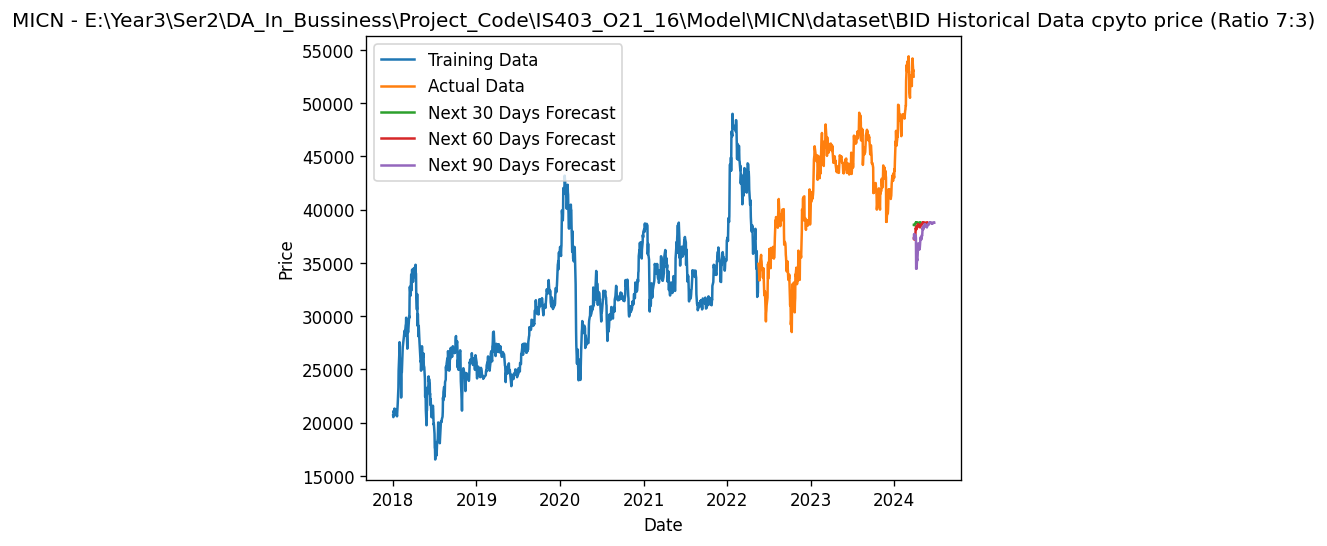

c:\Users\jiang\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\BID Historical Data.csv, Train Ratio: 0.8, Prediction Length: 90
RMSE: 6789.3802, MAPE: 14.20%, MAE: 6334.4923



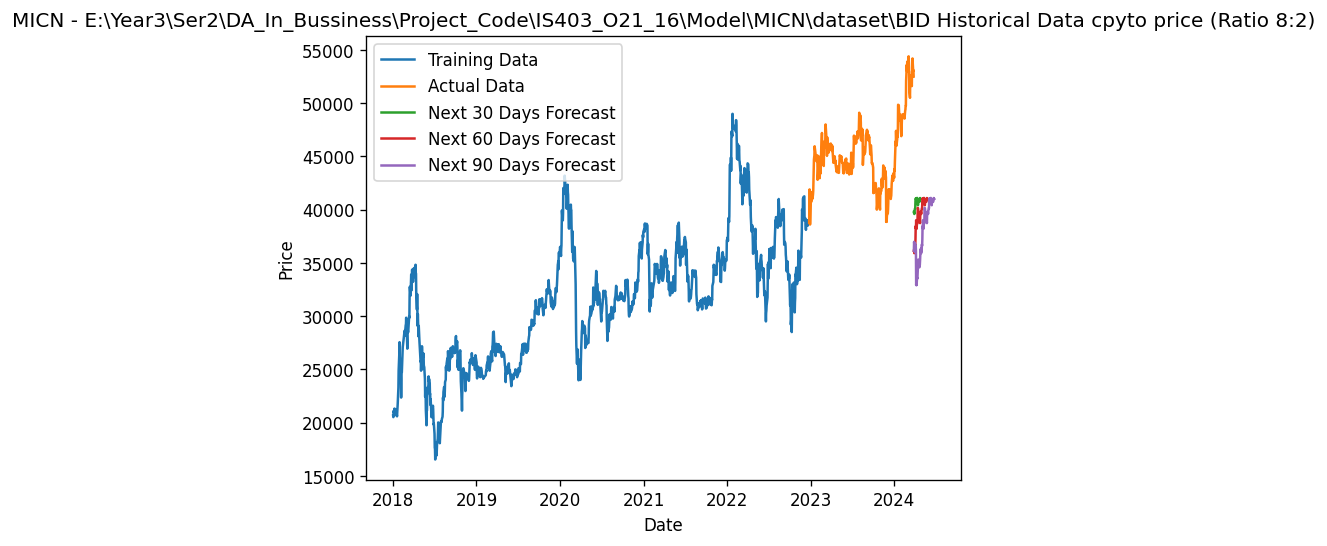

c:\Users\jiang\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\BID Historical Data.csv, Train Ratio: 0.9, Prediction Length: 90
RMSE: 5776.8356, MAPE: 9.81%, MAE: 4393.7695



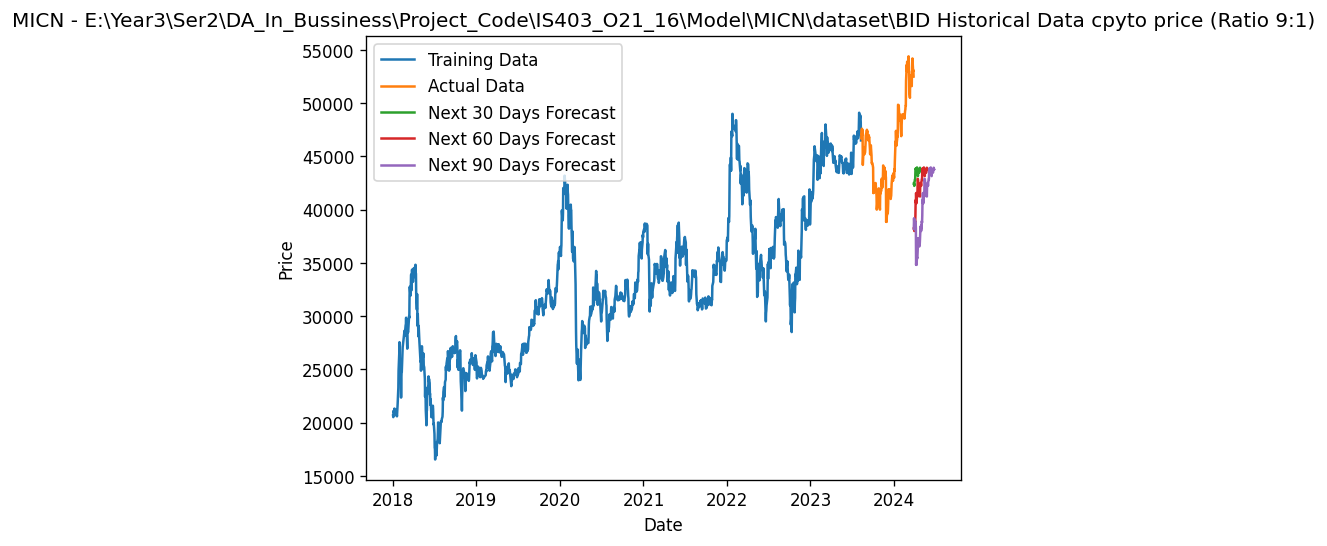

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1555 entries, 2018-01-02 to 2024-03-27
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1555 non-null   object
 1   Open      1555 non-null   object
 2   High      1555 non-null   object
 3   Low       1555 non-null   object
 4   Vol.      1555 non-null   object
 5   Change %  1555 non-null   object
dtypes: object(6)
memory usage: 85.0+ KB


c:\Users\jiang\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\MBB Historical Data.csv, Train Ratio: 0.7, Prediction Length: 90
RMSE: 3779.0321, MAPE: 12.82%, MAE: 2800.4959



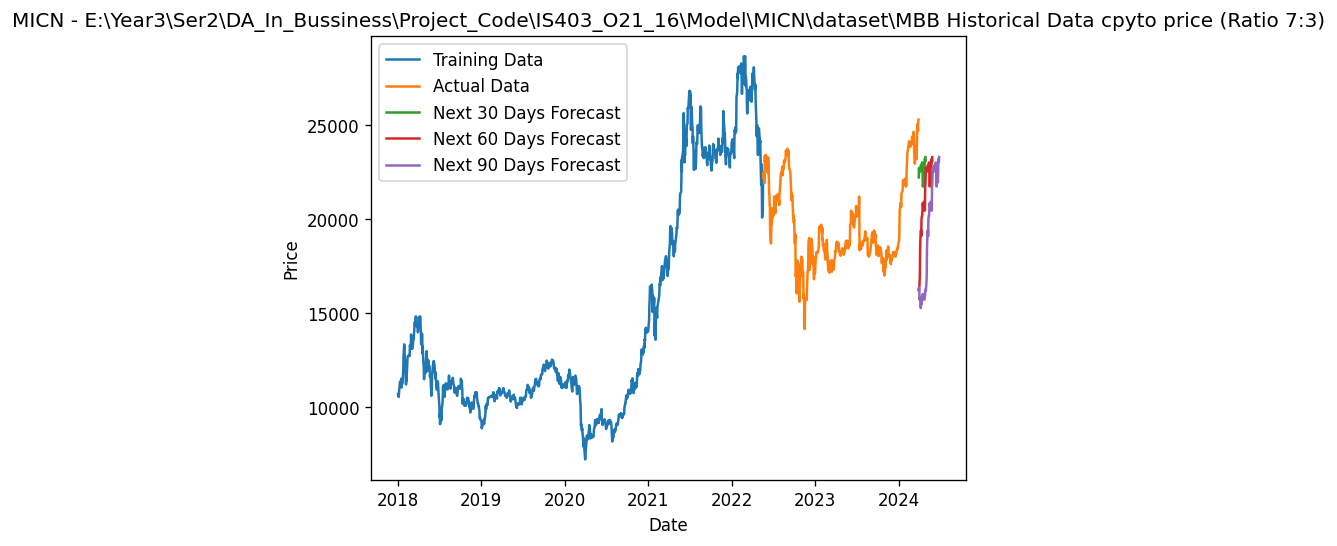

c:\Users\jiang\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\MBB Historical Data.csv, Train Ratio: 0.8, Prediction Length: 90
RMSE: 3325.0634, MAPE: 16.08%, MAE: 2917.3264



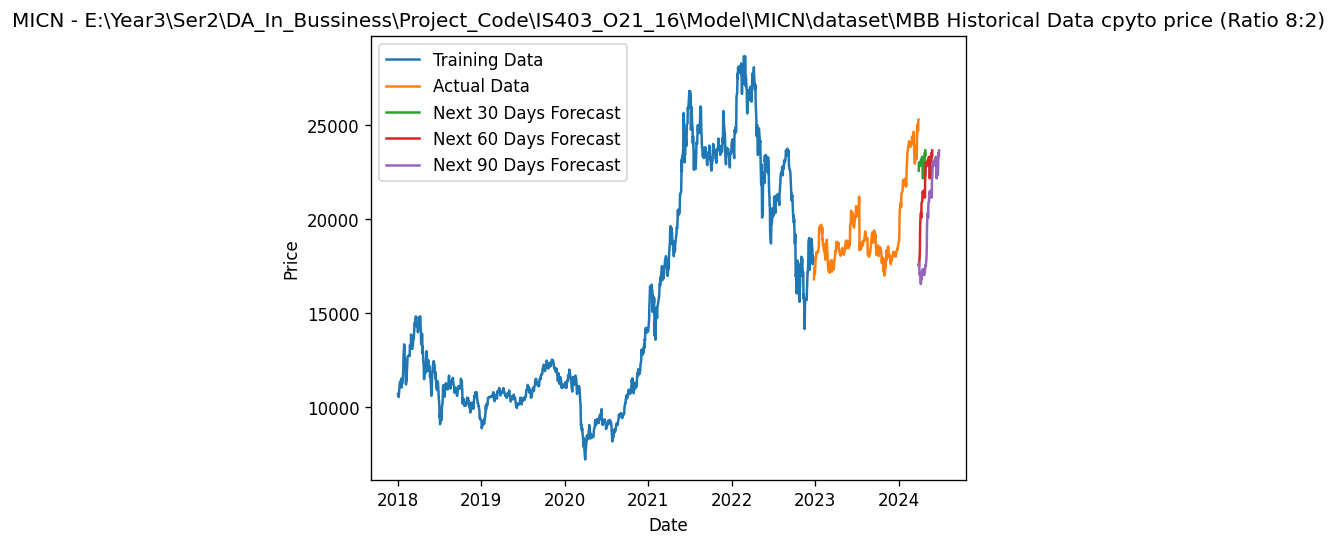

c:\Users\jiang\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\MBB Historical Data.csv, Train Ratio: 0.9, Prediction Length: 90
RMSE: 3228.4387, MAPE: 15.81%, MAE: 2860.7578



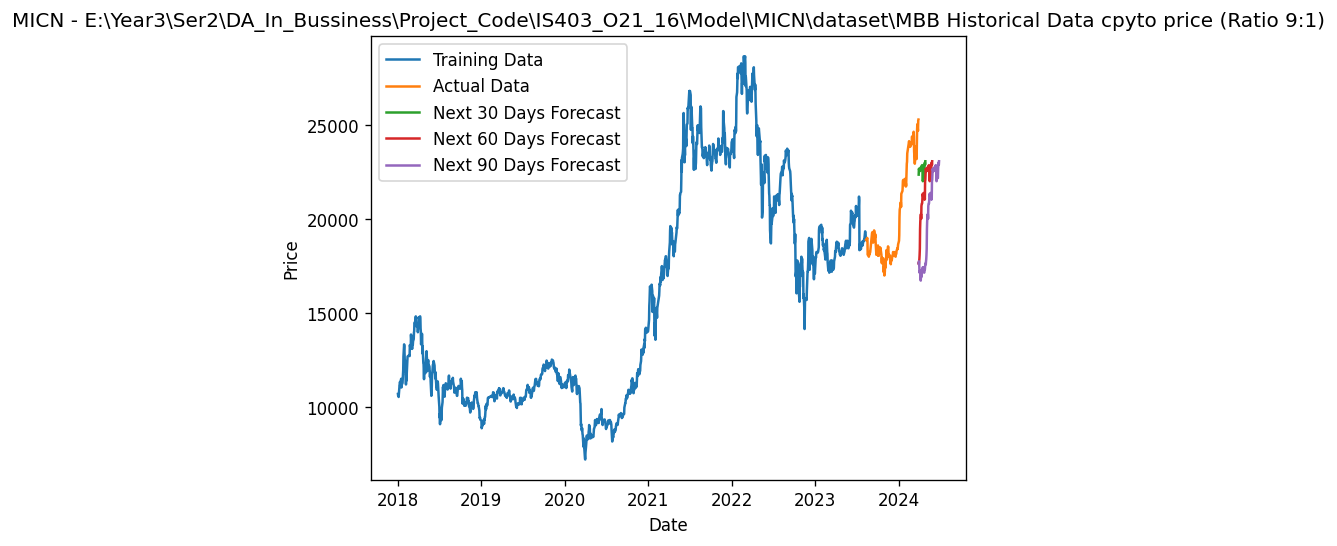

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1555 entries, 2018-01-02 to 2024-03-27
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1555 non-null   object
 1   Open      1555 non-null   object
 2   High      1555 non-null   object
 3   Low       1555 non-null   object
 4   Vol.      1555 non-null   object
 5   Change %  1555 non-null   object
dtypes: object(6)
memory usage: 85.0+ KB


c:\Users\jiang\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\VCB Historical Data.csv, Train Ratio: 0.7, Prediction Length: 90
RMSE: 3474.9202, MAPE: 3.83%, MAE: 2992.8299



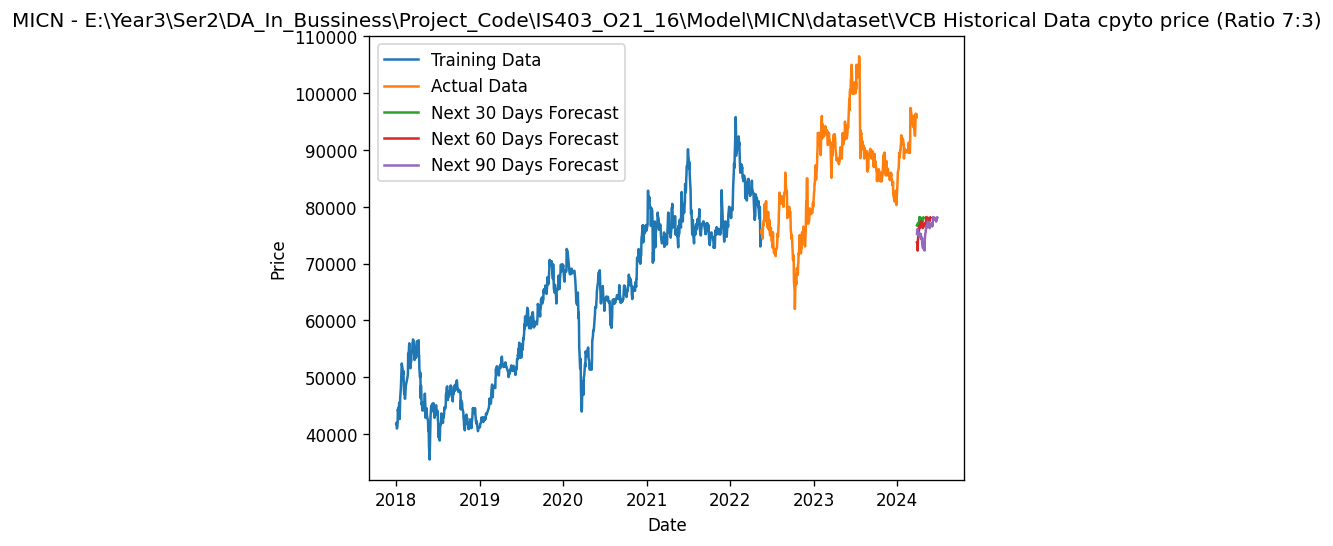

c:\Users\jiang\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\VCB Historical Data.csv, Train Ratio: 0.8, Prediction Length: 90
RMSE: 14833.9715, MAPE: 15.63%, MAE: 14179.3030



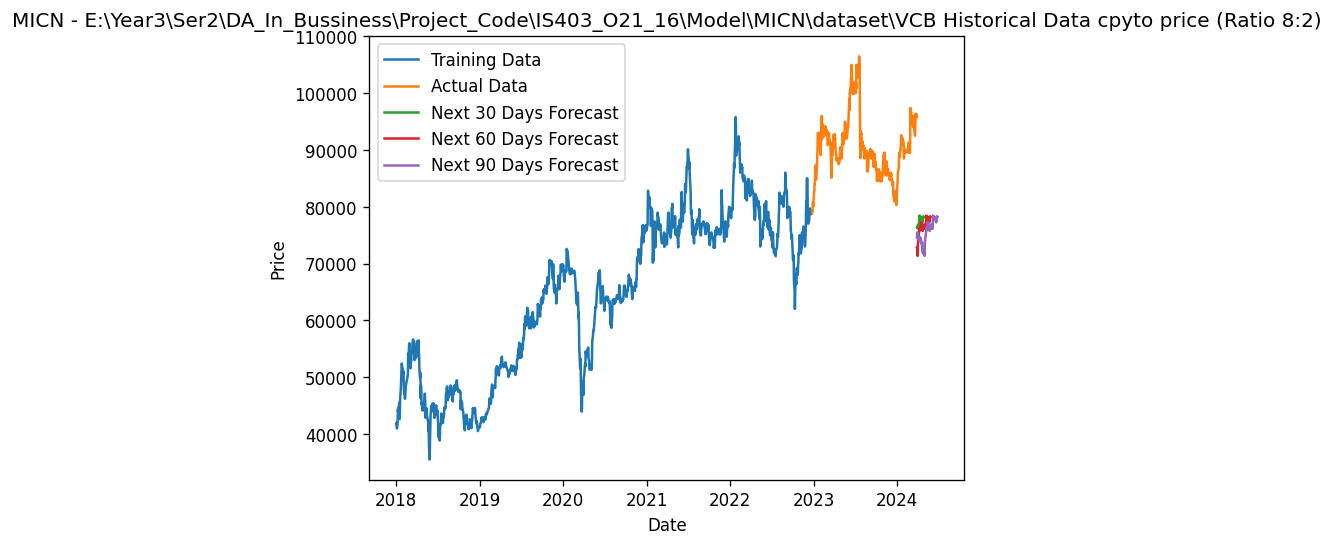

c:\Users\jiang\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\VCB Historical Data.csv, Train Ratio: 0.9, Prediction Length: 90
RMSE: 7426.0618, MAPE: 7.19%, MAE: 6321.8344



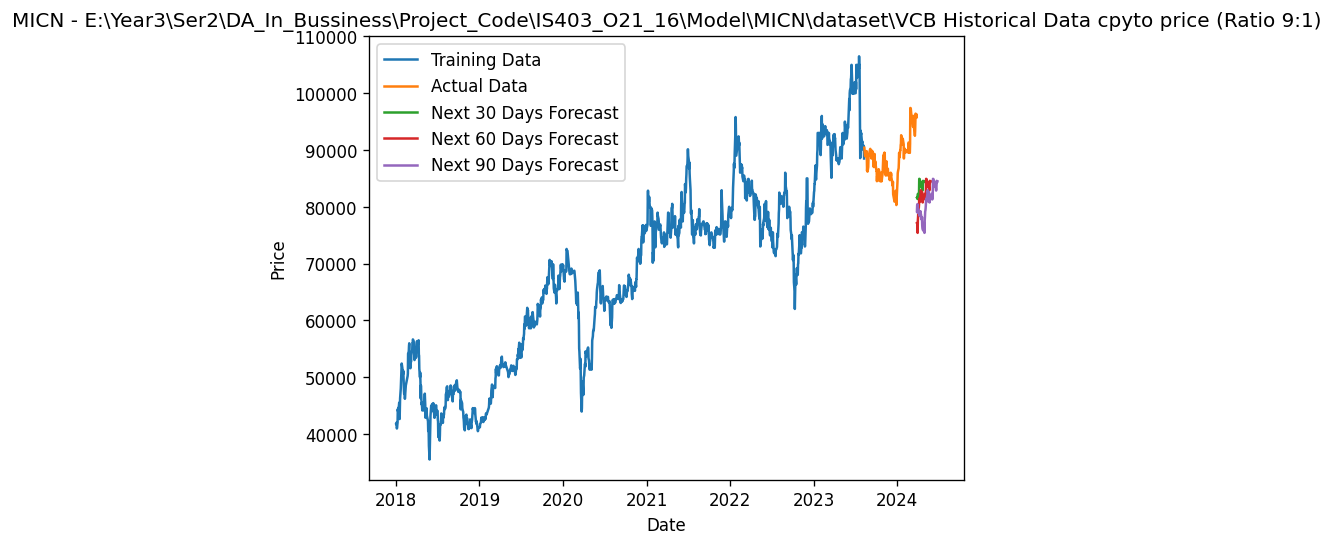

In [47]:
#Thực thi model 
datasets = ['E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\BID Historical Data.csv', 'E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\MBB Historical Data.csv', 'E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\VCB Historical Data.csv']
index_col = 'Date'
attribute = 'Price'
train_ratios = [0.7, 0.8, 0.9]
prediction_lengths = [30, 60, 90]

export_forecast_by_datasets(datasets, index_col, attribute, train_ratios, prediction_lengths)
